In [23]:
import numpy as np
from typing import List, Tuple
from numpy.typing import ArrayLike
from nn import NeuralNetwork, one_hot_encode_seqs, sample_seqs
from sklearn import datasets
from sklearn.model_selection import train_test_split,KFold
import pandas as pd
import matplotlib.pyplot as plt


### 5-fold CV Grid Search to find optimal NN architecture
* 5-fold Grid search CV was implemented manually to find optimal architecture (i.e, # of layers) hyperparameter 
* Data was split into train and test set. Test set was completely held out for the grid search CV; grid search hyperparameter tuning was done using only the training data. 
* Note that the grid search will take >1hr

In [71]:
## load and split data into train and test set. test set will be completely held out
# of grid search via cross validation.
np.random.seed(42)
digits = datasets.load_digits()
X = digits['data']
y = digits['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# perform Grid search via cross validation on the training data  
#training data will be split into train and validation set, while the original 
#test set is held out

#saving the average MSE across all epochs in each fold with each combination of proposed
#hyperparameters
columns = ["size","avg_train_error","avg_val_error"] + [f"train_error_fold_{x}" for x in range(1,6)] \
         + [f"val_error_fold_{x}" for x in range(1,6)]            
tuning_results_df = pd.DataFrame(columns = columns)


sizes = {2:
       [{'input_dim': 64, 'output_dim': 16, 'activation': 'relu'},  
       {'input_dim': 16, 'output_dim': 64, 'activation': 'relu'}],
    
       4:
        [{'input_dim': 64, 'output_dim': 32, 'activation': 'relu'},
       {'input_dim': 32, 'output_dim': 16, 'activation': 'relu'},
       {'input_dim': 16, 'output_dim': 32, 'activation': 'relu'},  
       {'input_dim': 32, 'output_dim': 64, 'activation': 'relu'}],
         
         6:
          [{'input_dim': 64, 'output_dim': 48, 'activation': 'relu'},
       {'input_dim': 48, 'output_dim': 32, 'activation': 'relu'},
       {'input_dim': 32, 'output_dim': 16, 'activation': 'relu'},
       {'input_dim': 16, 'output_dim': 32, 'activation': 'relu'},
       {'input_dim': 32, 'output_dim': 48, 'activation': 'relu'},
       {'input_dim': 48, 'output_dim': 64, 'activation': 'relu'}],
         







kf = KFold(n_splits=5)
df_idx = 0
for size in sizes:
    print(size)
    fold_avg_train_losses = []
    fold_avg_val_losses = []
    for fold_idx, (train,val) in enumerate(kf.split(X_train,y_train)):
        fold_idx = fold_idx + 1
        
        
        # fit NN using current architecture size (i.e, 2 layers, 4 layers, etc)
        # using stochastic gradient descent
        nn = NeuralNetwork(nn_arch=sizes[size],
                       lr=0.001, batch_size=1, seed=42, epochs=500, 
                        loss_function='mean_squared_error') 
        #fit this fold. test data is still held out
        train_loss, val_loss = nn.fit(X_train[train],y_train[train],
                                       X_train[val],y_train[val])
        fold_avg_train_loss = np.mean(train_loss) #avg (across epochs) training loss for this fold
        fold_avg_train_losses.append(fold_avg_train_loss)

        fold_avg_val_loss = np.mean(val_loss) #avg (across epochs) validation loss for this fold
        fold_avg_val_losses.append(fold_avg_val_loss)


        #store hyperparameters and per-fold results
        tuning_results_df.loc[df_idx,"size"]=size
        tuning_results_df.loc[df_idx,f"train_error_fold_{fold_idx}"] = fold_avg_train_loss
        tuning_results_df.loc[df_idx,f"val_error_fold_{fold_idx}"] = fold_avg_val_loss

    #store average train and val loss across all folds for this combination of hyperparameters
    tuning_results_df.loc[df_idx,"avg_train_error"] = np.mean(fold_avg_train_losses)
    tuning_results_df.loc[df_idx,"avg_val_error"] = np.mean(fold_avg_val_losses)

    df_idx +=1
            

2
4
6
8


ValueError: shapes (1,56) and (54,48) not aligned: 56 (dim 1) != 54 (dim 0)

In [81]:
#resulting dataframe stores error from each fold with each combination of hyperparameters
#as well as the average error across all 5 folds with each combnation of hyperparameters
display(tuning_results_df)

,size,avg_train_error,avg_val_error,train_error_fold_1,train_error_fold_2,train_error_fold_3,train_error_fold_4,train_error_fold_5,val_error_fold_1,val_error_fold_2,val_error_fold_3,val_error_fold_4,val_error_fold_5
0,2,8.170597,8.163216,7.594967,7.922113,8.018097,8.547432,8.770379,7.120172,8.093121,8.465553,8.63345,8.503786
1,4,6.080416,6.10391,4.266077,6.291071,6.826829,6.26392,6.754185,3.987092,6.256604,7.224299,6.380818,6.670737
2,6,7.868176,7.865956,6.009164,6.859886,6.232084,13.899059,6.340684,5.626828,6.896004,6.602483,13.911804,6.292663
3,8,NaN,NaN,14.072019,NaN,12.221626,5.847786,14.012945,13.215926,NaN,12.844092,5.970574,13.25842


In [83]:
#get data for combination of hyperparameters that gave the lowest average MSE
# across epochs and folds in the validation set
display(tuning_results_df.loc[tuning_results_df['avg_val_error'].astype(float).idxmin()])
best_nn_size = tuning_results_df.loc[tuning_results_df['avg_val_error'].astype(float).idxmin(),'size']

print(f"The optimal neural network had {best_nn_size} layers")


size                         4
avg_train_error       6.080416
avg_val_error          6.10391
train_error_fold_1    4.266077
train_error_fold_2    6.291071
train_error_fold_3    6.826829
train_error_fold_4     6.26392
train_error_fold_5    6.754185
val_error_fold_1      3.987092
val_error_fold_2      6.256604
val_error_fold_3      7.224299
val_error_fold_4      6.380818
val_error_fold_5      6.670737
Name: 1, dtype: object

The optimal neural network had 4 layers


#### Re-training model with optimal set of hyperparameters and plotting per-epoch train and test MSE

* I tuned the architecture (i.e # of layers) hyperparameter of the neural network by implementing a cross-validated grid search; the size of the NN that minimized the average across-fold MSE was used moving forward. A subset of samples were completely held out from this procedure to be used for validation/testing here. 
* These results suggest the model was able to learn from the training data, as the training loss decreased as the number of epochs increased. After about 2 epochs, the validation loss began to plateau, suggesting the model was beginning to overfit to the training data after this point,

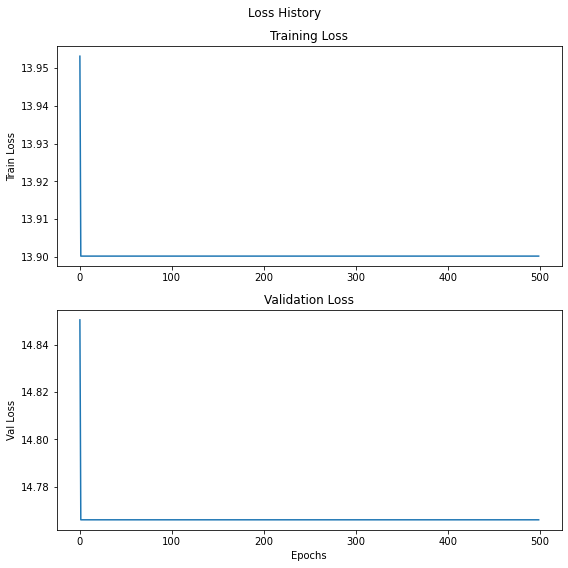

In [85]:
nn = NeuralNetwork(nn_arch = sizes[best_nn_size],
                       lr=0.001, batch_size=1, seed=42, epochs=500, 
                        loss_function='mean_squared_error')

#X_train and y_train are the same observations that were used for cross validation grid search
#X_test and y_test were completely held out of the grid search procedure
per_epoch_train_loss, per_epoch_val_loss = nn.fit(X_train,y_train,
                                               X_test,y_test)



loss_hist = per_epoch_train_loss
loss_hist_val = per_epoch_val_loss
assert len(loss_hist) > 0, "Need to run training before plotting loss history"
fig, axs = plt.subplots(2, figsize=(8,8))
fig.suptitle('Loss History')
axs[0].plot(np.arange(len(loss_hist)), loss_hist)
axs[0].set_title('Training Loss')
axs[1].plot(np.arange(len(loss_hist_val)), loss_hist_val)
axs[1].set_title('Validation Loss')
plt.xlabel('Epochs')
axs[0].set_ylabel('Train Loss')
axs[1].set_ylabel('Val Loss')
fig.tight_layout()
plt.show() 

### Average reconstruction error over held out test dataset
* Take trained model and form predictions on entire datase then calculate MSE across the held out test dataset

In [86]:

#average MSE from unseen test data
test_predictions = nn.predict(X_test)
test_reconstruction_error = nn._mean_squared_error(X_test,test_predictions)
print(f"Average reconstruction error over unseen test data {test_reconstruction_error}")

Average reconstruction error over unseen test data 29.955334595959595


In [128]:
np.random.seed(42)
X = np.array([[1,1,1],
                  [2,2,2],
                  [3,3,3]])

test= NeuralNetwork(nn_arch=[{'input_dim': 3, 'output_dim': 2, 'activation': 'relu'},
                        {'input_dim': 2, 'output_dim': 3, 'activation': 'relu'}],
                       lr=0.001, batch_size=3, seed=42, epochs=25,
                       loss_function='mean_squared_error')

test._param_dict = {'W1': np.array([[ 0.5, 0.5,  0.5],
                    [ 0.5, 0.5, 0.5 ]]),
             'b1': np.array([[1.0],
                            [1.0]]),
             'W2': np.array([[0.5,  0.5 ],
                    [0.5, 0.5],
                    [ 0.5, 0.5]]),
             'b2': np.array([[1.0],
                            [1.0],
                            [1.0]])}

In [129]:
output,cache = test.forward(X)

In [146]:
Z_curr = cache["Z2"]
dZdW = cache["A1"]
dAdZ = test._activation_function_backprop(Z_curr, 'relu')
dJdA = dJdA = (output - X) / X.size
delta = np.multiply(dJdA, dAdZ)

In [148]:
dW_curr = delta.T.dot(dZdW)
db_curr = np.sum(delta,axis = 0,keepdims=True).T

In [147]:
delta

array([[0.27777778, 0.27777778, 0.27777778],
       [0.33333333, 0.33333333, 0.33333333],
       [0.38888889, 0.38888889, 0.38888889]])

In [151]:
dW_curr

array([[4.16666667, 4.16666667],
       [4.16666667, 4.16666667],
       [4.16666667, 4.16666667]])

In [127]:
np.allclose(dW_curr,dW_curr) and np.allclose(dW_curr,dW_curr)

True

In [142]:
y.size

1797

In [134]:
dW_curr

array([[12.5, 12.5],
       [12.5, 12.5],
       [12.5, 12.5]])